In [761]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import pandas as pd
import os
import cv2 as cv
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.utils
import time
import wandb
import random
import math

In [762]:
class Transform():
    def __init__(self):
        pass
    def Crop(self, image, x_coords, y_coords):    
        x1 = x_coords.min() - 20
        x2 = x_coords.max() + 20
        y1 = y_coords.max() + 20
        y2 = y_coords.min() - 20
        
        image = TF.crop(image, int(y2), int(x1), int(y1-y2), int(x2-x1))
        return image, y2, x1
    def Resize(self, image, img_size):
        image = TF.resize(image, img_size)
        newSize = image.size
        return image, newSize
    def ChangeCoords(self, initialSize, newSize, x_coords, y_coords):
        Xratio = newSize[0]/initialSize[0]
        Yratio = newSize[1]/initialSize[1]
        
        for i in range(0, len(x_coords)):
            x_coords[i] = x_coords[i] * Xratio
            y_coords[i] = y_coords[i] * Yratio
        return x_coords, y_coords
    def CropCoords(self, image, top, left, x_coords, y_coords):
        for i in range(0, len(x_coords)):
            x_coords[i] = x_coords[i] - left
            y_coords[i] = y_coords[i] - top
        return x_coords, y_coords
    def rotate_image_and_landmarks(self, image, landmarks, angle):       
        landmarks = np.array(landmarks).reshape(-1, 2)
        image_shape = image.shape[-2:]
        center = (image_shape[1] / 2, image_shape[0] / 2)
        pil_image = TF.to_pil_image(image)
        rotated_image = TF.rotate(pil_image, angle, center=center)
        translated_landmarks = landmarks - center
        angle_rad = np.radians(-angle)
        rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                    [np.sin(angle_rad), np.cos(angle_rad)]])
        rotated_landmarks = np.dot(translated_landmarks, rotation_matrix.T)
        rotated_landmarks = rotated_landmarks + center
        rotated_image = TF.to_tensor(rotated_image)
        rotated_landmarks = rotated_landmarks.reshape(-1)
        return rotated_image, rotated_landmarks
    def mirror_image_and_landmarks(self, image, landmarks):
        width = image.shape[2]
        mirrored_image = torch.flip(image, [2])
        mirrored_landmarks = landmarks.copy()
        mirrored_landmarks[0::2] = width - landmarks[0::2]
        return mirrored_image, mirrored_landmarks
    def cutout(self, image_tensor, mask_size):
        _, height, width = image_tensor.shape
        mask_value = torch.mean(image_tensor)

        top = random.randint(0, height - mask_size)
        left = random.randint(0, width - mask_size)
        bottom = top + mask_size
        right = left + mask_size

        image_tensor[:, top:bottom, left:right] = mask_value

        return image_tensor
    def __call__(self, img, x_coords, y_coords):
        img = Image.fromarray(img)
        img, top, left = self.Crop(img, x_coords, y_coords)
        cropSize = img.size
        x_coords, y_coords = self.CropCoords(img, top, left, x_coords, y_coords)
        img, newSize = self.Resize(img, (224, 224))
        x_coords, y_coords = self.ChangeCoords(cropSize, newSize, x_coords, y_coords)
        img = TF.to_grayscale(img, 1)
        img = TF.to_tensor(img)
        #########################################
        #img = TF.normalize(img, [0.5], [0.5])  #
        #########################################
        # Images look really wonky when normalized, will look into it
        landmarks = np.array([])
        for i in range(0, 16):
            landmarks = np.append(landmarks, x_coords[i])
            landmarks = np.append(landmarks, y_coords[i])
        
        was_rotated = False
        was_mirrored = False
        
        if random.uniform(0, 1) > 0.5:
            angle = 10
            img, landmarks = self.rotate_image_and_landmarks(img, landmarks, angle)
            was_rotated = True
        if random.uniform(0, 1) > 0.5:
            img, landmarks = self.mirror_image_and_landmarks(img, landmarks)
            was_mirrored = True
        if random.uniform(0, 1) > 0.5:
            img = self.cutout(img, 30)
        
        landmarks_tensor = torch.tensor(landmarks, dtype=torch.float32)
        
        return img, landmarks_tensor, cropSize, left, top, was_rotated, was_mirrored

In [763]:
class Body_Dataset():
    def __init__(self, df, root_dir, transform = None):
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, str(self.annotations.iloc[index, 1]))
        image = cv.imread(img_path)
        landmarks = self.annotations.iloc[index, 2:-3]
        x_coords = np.array([])
        y_coords = np.array([])
        for i in range(0, 32, 2):
            x_coords = np.append(x_coords, landmarks[i])
            y_coords = np.append(y_coords, landmarks[i+1])
        x_coords_tensor = torch.tensor(x_coords, dtype=torch.float32)
        y_coords_tensor = torch.tensor(y_coords, dtype=torch.float32)
        if self.transform:
            image, landmarks, cropSize, x, y, was_rotated, was_mirrored = self.transform(image, x_coords_tensor, y_coords_tensor)
        return image, landmarks, cropSize, x, y, was_rotated, was_mirrored

In [764]:
os.path.getsize('images')

24986

In [765]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Hyper Paramaters
num_classes = 32
num_epochs = 60
batch_size = 1
learning_rate = 0.001
error = 2

#Get Rid of -1 in DS
bruh = pd.read_csv("MPII_Human_Pose.csv")
filtered_df = bruh[~(bruh == -1).any(axis=1)]
filtered_df


#Load Data
dataset = Body_Dataset(df = filtered_df, root_dir = 'images', transform = Transform())

#
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [10000, 1231])
train_loader = DataLoader(dataset= train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset= test_dataset, batch_size = batch_size, shuffle = True)
images, landmarks, size, x_test, y_test, was_rotated, was_mirrored = next(iter(train_loader))

tensor([False])
tensor([True])


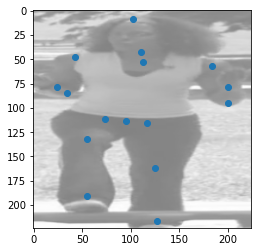

In [766]:
x = [landmarks[0][0].item(), landmarks[0][2].item(), landmarks[0][4].item(), landmarks[0][6].item(), landmarks[0][8].item(), landmarks[0][10].item(), landmarks[0][12].item(), landmarks[0][14].item(), landmarks[0][16].item(), landmarks[0][18].item(), landmarks[0][20].item(), landmarks[0][22].item(), landmarks[0][24].item(), landmarks[0][26].item(), landmarks[0][28].item(), landmarks[0][30].item()]
y = [landmarks[0][1].item(), landmarks[0][3].item(), landmarks[0][5].item(), landmarks[0][7].item(), landmarks[0][9].item(), landmarks[0][11].item(), landmarks[0][13].item(), landmarks[0][15].item(), landmarks[0][17].item(), landmarks[0][19].item(), landmarks[0][21].item(), landmarks[0][23].item(), landmarks[0][25].item(), landmarks[0][27].item(), landmarks[0][29].item(), landmarks[0][31].item()]

def imshow(img, x, y):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.scatter(x, y)
    plt.show()

print(was_rotated)
print(was_mirrored)
imshow(torchvision.utils.make_grid(images), x, y)

In [771]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Network(nn.Module):
    
    def __init__(self,num_classes=32):
        super().__init__()
        self.model_name='resnet101'
        self.model=models.resnet101()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

model = Network().to(device)

#Loss and Optimizer functions
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

loss_min = np.inf

In [ ]:
for epoch in range(1,num_epochs+1): #epoch is how many times you go through the dataset
    start_time = time.time()
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    model.train()
    n_total_steps = len(train_loader)
    for step in range(1,len(train_loader)+1):  #going through the dataset
    
        images, landmarks, Size, x, y, was_rotated, was_mirrored = next(iter(train_loader))
        
        images = images.to(device)
        landmarks = landmarks.view(landmarks.size(0),-1).to(device)
        
        predictions = model(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step       
        
        if step % 100 == 0:
            print(f'Running Training Loss {step}/{n_total_steps}: {running_loss}')
    
    model.eval() 
    with torch.no_grad():
        n_total_steps = len(test_loader)
        n_samples = batch_size * num_classes
        running_percent = 0
        counter = 0
        for step in range(1,len(test_loader)+1):
            
            images, landmarks, Size, x, y, was_rotated, was_mirrored = next(iter(test_loader))
        
            images = images.to(device)
            landmarks = landmarks.view(landmarks.size(0),-1).to(device)
        
            predictions = model(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step
            
            if step % 100 == 0:
                print(f'Running Validation Loss {step}/{n_total_steps}: {running_loss}')
           
            for j in range(0, batch_size):
                width = Size[0][j]
                height = Size[1][j]
                Xratio = width/224
                Yratio = height/224
                
                n_correct = 0
                accuracy = 0
                percent = 0
                
                x_coord = []
                y_coord = []
                
                
                if(was_mirrored == True):
                    width = 224
                    temp1 = np.array([x.item() for x in landmarks[j]])
                    mirrored_landmarks = temp1.copy()
                    mirrored_landmarks[0::2] = width - temp1[0::2]
                    tensor_shape = (1, len(mirrored_landmarks))
                    landmarks = torch.tensor(mirrored_landmarks, device='cuda:0').reshape(tensor_shape)
                    
                    
                    temp2 = np.array([x.item() for x in predictions[j]])
                    mirrored_predictions = temp2.copy()
                    mirrored_predictions[0::2] = width - temp2[0::2]
                    tensor_shape = (1, len(mirrored_predictions))
                    predictions = torch.tensor(mirrored_predictions, device='cuda:0').reshape(tensor_shape)
                
                if(was_rotated == True):
                    temp1 = np.array([x.item() for x in landmarks[j]])
                    landmarks = np.array(temp1).reshape(-1, 2)
                    image_shape = [224, 224]
                    center = (image_shape[1] / 2, image_shape[0] / 2)
                    translated_landmarks = landmarks - center
                    angle_rad = np.radians(10)
                    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                                [np.sin(angle_rad), np.cos(angle_rad)]])
                    rotated_landmarks = np.dot(translated_landmarks, rotation_matrix.T)
                    rotated_landmarks = rotated_landmarks + center
                    rotated_landmarks = rotated_landmarks.reshape(-1)
                    tensor_shape = (1, len(rotated_landmarks))
                    landmarks = torch.tensor(rotated_landmarks, device='cuda:0').reshape(tensor_shape)
                    
                    temp2 = np.array([x.item() for x in predictions[j]])
                    predictions = np.array(temp2).reshape(-1, 2)
                    image_shape = [224, 224]
                    center = (image_shape[1] / 2, image_shape[0] / 2)
                    translated_predictions = predictions - center
                    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                                [np.sin(angle_rad), np.cos(angle_rad)]])
                    rotated_predictions = np.dot(translated_predictions, rotation_matrix.T)
                    rotated_predictions = rotated_predictions + center
                    rotated_predictions = rotated_predictions.reshape(-1)
                    tensor_shape = (1, len(rotated_predictions))
                    predictions = torch.tensor(rotated_predictions, device='cuda:0').reshape(tensor_shape)
                
                
                for i in range(0, 32):
                    if i%2 == 0:
                        landmarks[j][i] = landmarks[j][i] * Xratio
                        landmarks[j][i] = landmarks[j][i] + x[j]
                        x_coord.append(landmarks[j][i])
                        predictions[j][i] = predictions[j][i] * Xratio
                        predictions[j][i] = predictions[j][i] + x[j]
                        
                    else:
                        landmarks[j][i] = landmarks[j][i] * Yratio
                        landmarks[j][i] = landmarks[j][i] + y[j]
                        y_coord.append(landmarks[j][i])
                        predictions[j][i] = predictions[j][i] * Yratio
                        predictions[j][i] = predictions[j][i] + y[j]
                    validation = predictions[j][i].item() - landmarks[j][i].item()
                    if validation > 0:
                        if validation <= error:
                            n_correct = n_correct + 1
                    if validation < 0:
                        if validation >= -error:
                            n_correct = n_correct + 1
                accuracy = n_correct/n_samples
                percent = 100 * accuracy
                running_percent = running_percent + percent
    average_percent = running_percent/len(test_loader)
    loss_train /= len(train_loader)
    loss_valid /= len(test_loader)
    
    acc = average_percent/100
    
    print('\n--------------------------------------------------')
    print(f'Average accuracy: {average_percent}%')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print("Total Elapsed Time : {} s".format(time.time()-start_time))
    print('--------------------------------------------------')

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(model.state_dict(), './HumanPose_resnet101_60_epoch.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
    scheduler.step()      

Running Training Loss 100/10000: 3870.836221923828


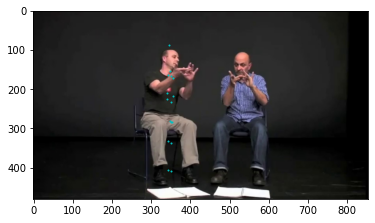

In [690]:
#The path of the model
weights_path = 'HumanPose_resnet101_60_epoch.pth'

#The path of the image being plotted on
image_path = 'images/030424224.jpg'

#These are the orignal landmarks for that image
original_x = [324, 322, 293, 355, 401, 394, 324, 334, 338.6651, 360.3349, 363, 319, 298, 369, 390, 398]
original_y = [406, 291, 262, 267, 292, 404, 265, 170, 157.2087, 97.7913, 167, 205, 168, 172, 221, 179]


x = int(max(original_x) + 20)
y = int(min(original_y) - 20)
w = int(min(original_x) - 20)
h = int(max(original_y) + 20)


best_network = Network()
best_network.load_state_dict(torch.load(weights_path, map_location=torch.device('cuda')), strict=False) 
best_network.eval()

image = cv.imread(image_path)
display_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = display_image[y:h, w:x]
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

height, width = image.shape
Xratio = width/224
Yratio = height/224
image = TF.resize(Image.fromarray(image), size=(224, 224))
image = TF.to_tensor(image)
#image = TF.normalize(image, [0.5], [0.5])

with torch.no_grad():
    landmarks = best_network(image.unsqueeze(0))
    
for i in range(0, 32):
    if i%2 == 0:
        landmarks[0][i] = landmarks[0][i] * Xratio
        landmarks[0][i] = landmarks[0][i] + w
    else:
        landmarks[0][i] = landmarks[0][i] * Yratio
        landmarks[0][i] = landmarks[0][i] + y
    
plt.figure()
plt.imshow(display_image)

index = 0
for i in range (0, 32, 2):
    plt.scatter(landmarks[0][i], landmarks[0][i+1], c = 'c', s = 1)

[201.71499633789062, 159.00546264648438, 112.3178939819336, 113.222412109375, 161.6105194091797, 203.02613830566406, 112.9261245727539, 51.616539001464844, 43.239253997802734, 10.645132064819336, 84.78060150146484, 75.31047058105469, 51.067626953125, 52.08528137207031, 77.19498443603516, 86.95513153076172]


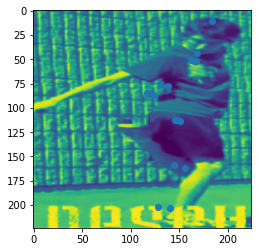

In [426]:
weights_path = 'HumanPose_resnet101_60_epoch.pth'
image_path = 'images/094426649.jpg'

original_x = [391, 418, 401, 410, 402, 359, 406, 396, 402.3095, 431.6905, 290, 332, 377, 415, 403, 394]
original_y = [432, 346, 239, 237, 354, 300, 238, 158, 146.8833, 95.1167, 230, 200, 159, 156, 201, 238]


x2 = int(max(original_x) + 20)
y2 = int(min(original_y) - 20)
x1 = int(min(original_x) - 20)
y1 = int(max(original_y) + 20)

best_network = Network()
best_network.load_state_dict(torch.load(weights_path, map_location=torch.device('cuda')), strict=False) 
best_network.eval()

image = cv.imread(image_path)
image = Image.fromarray(image)
image = TF.crop(image, int(y2), int(x1), int(y1-y2), int(x2-x1))
image = TF.resize(image, size=(224, 224))
image = TF.to_grayscale(image, 1)
image = TF.to_tensor(image)
#image = TF.normalize(image, [0.5], [0.5])


def imshow(img, x, y):
    #img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.scatter(x, y)
    plt.show()
    
with torch.no_grad():
    landmarks = best_network(image.unsqueeze(0))

x = []
y = []
for i in range(len(landmarks[0])):
    if i%2 == 0:
        x.append(float(landmarks[0][i]))
    else:
        y.append(float(landmarks[0][i]))

print(y)

imshow(image, x, y)